In [1]:
library(rhdf5)
library(MASS)
# library(BoutrosLab.plotting.general)
library(ggplot2)
library(repr)
# Change plot size to BIG
options(repr.plot.width=20, repr.plot.height=10)

# Test reading h5 and accessing data

In [2]:
fh <- "/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/sim.h5"

Get internal structure of h5 file

In [3]:
h5ls(fh)

,group,name,otype,dclass,dim
,<chr>,<chr>,<chr>,<chr>,<chr>
0,/,coeffs,H5I_DATASET,COMPOUND,13000
1,/,counts,H5I_GROUP,,
2,/counts,continuous,H5I_DATASET,INTEGER,13000 x 50000
3,/counts,discrete,H5I_DATASET,INTEGER,13000 x 50000
4,/,guides,H5I_GROUP,,
5,/guides,est_efficiency_D10,H5I_DATASET,FLOAT,4000
6,/guides,est_efficiency_D100,H5I_DATASET,FLOAT,4000
7,/guides,metadata,H5I_DATASET,COMPOUND,4000
8,/guides,one_hot,H5I_DATASET,INTEGER,50000 x 4000


In [4]:
counts.dis.rowsums <- rowSums(h5read(file = fh, name = "counts/discrete"))
counts.cont.rowsums <- rowSums(h5read(file = fh, name = "counts/continuous"))

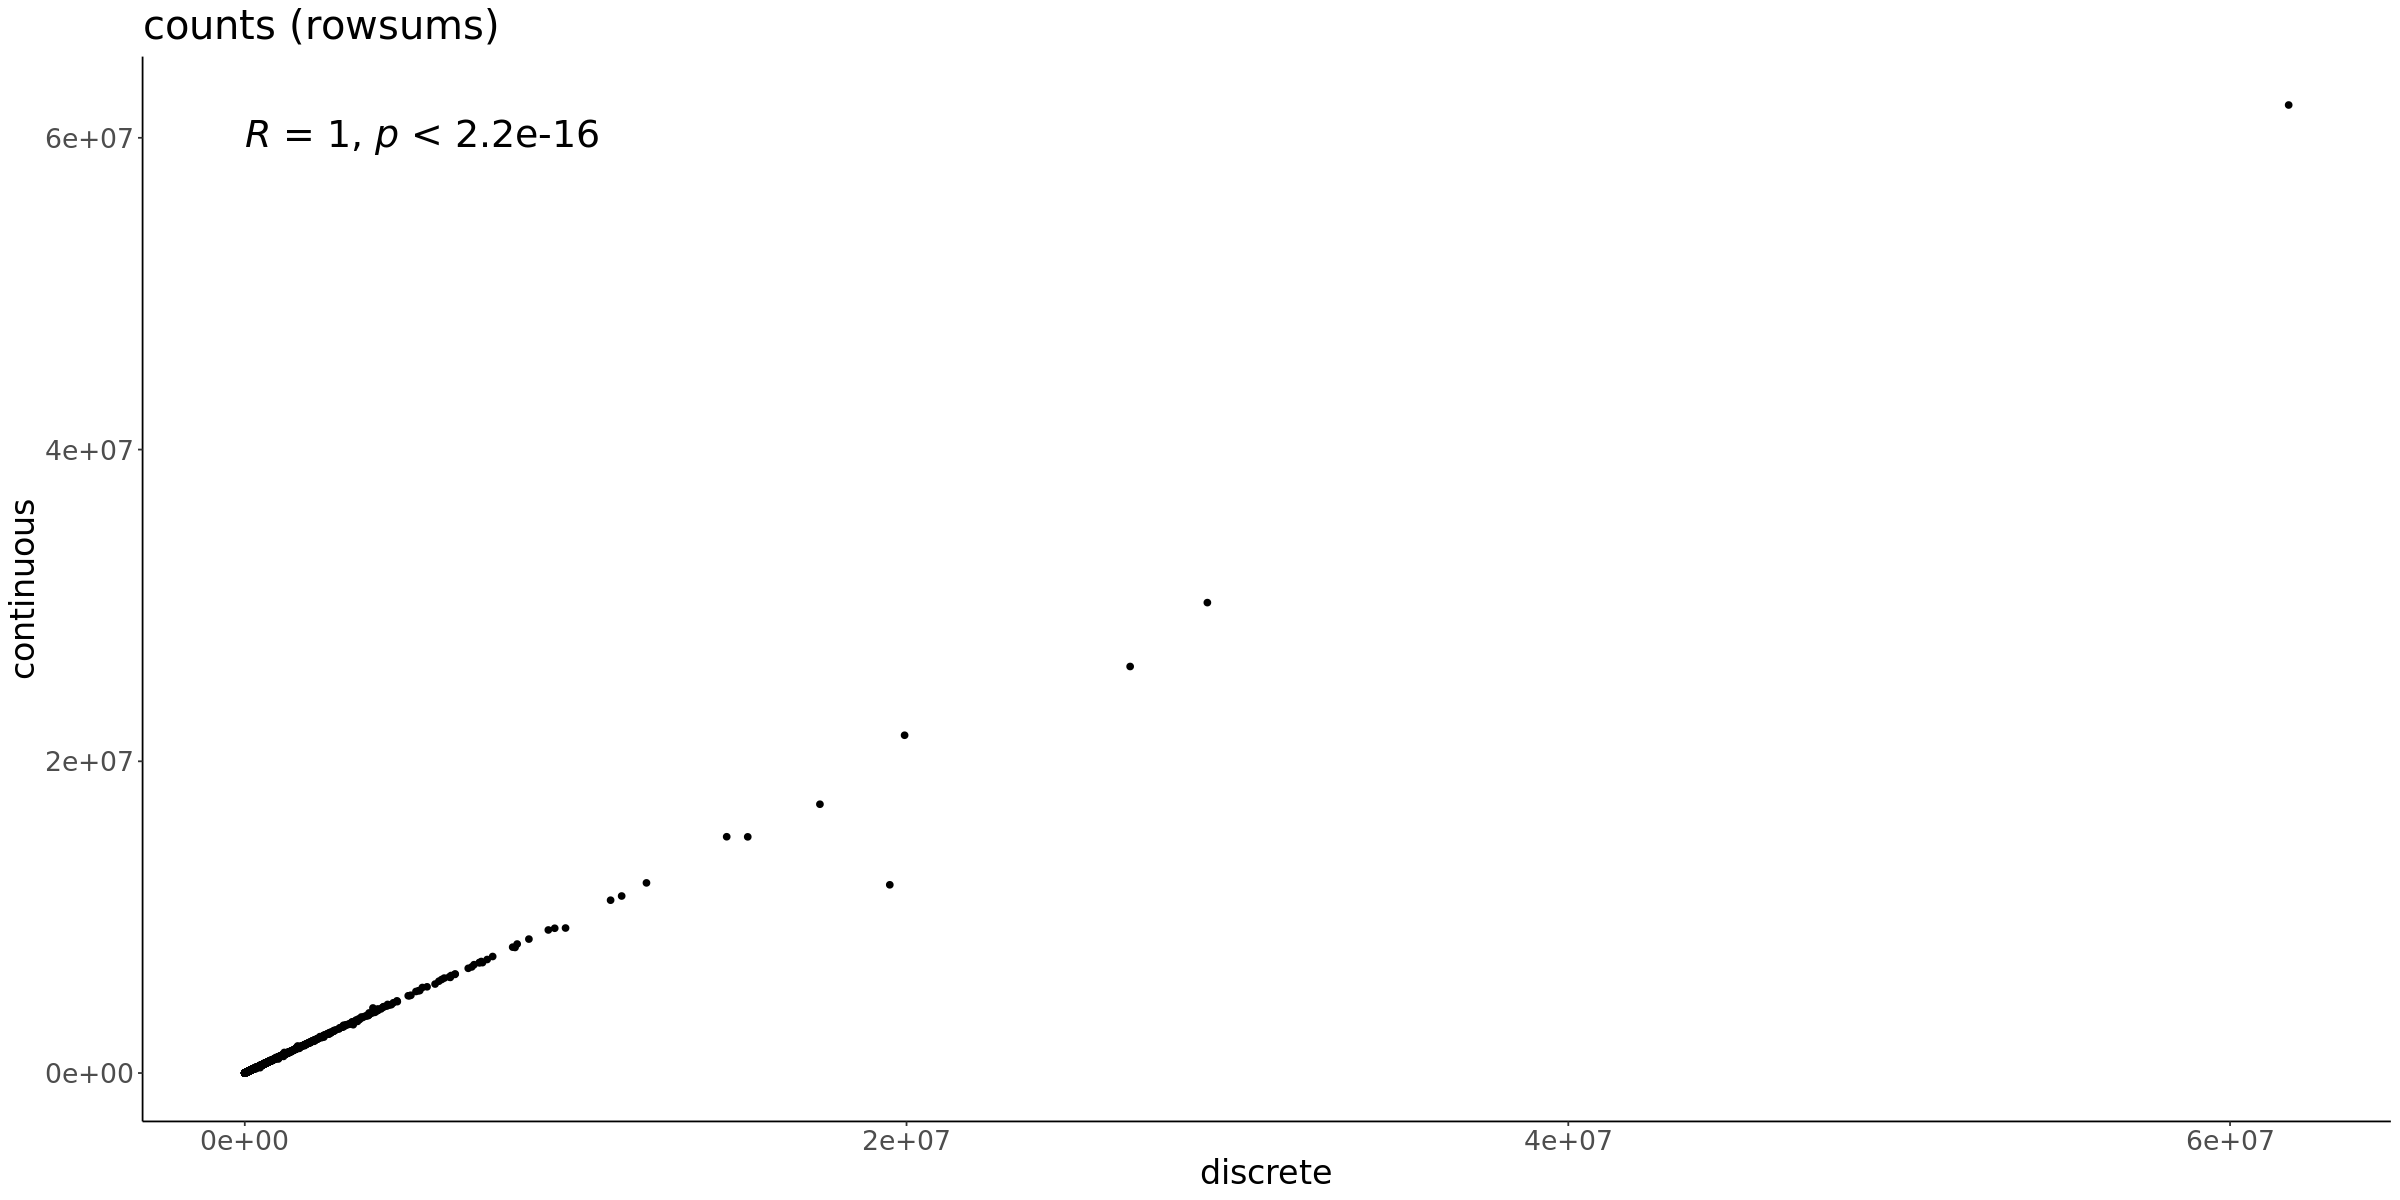

In [5]:
counts.rowsums.df <- data.frame(discrete = counts.dis.rowsums, continuous = counts.cont.rowsums)

counts.scatter <- ggplot(counts.rowsums.df, aes(x = discrete, y = continuous)) + geom_point() + 
                theme_classic() + theme(text = element_text(size = 20)) + ggtitle("counts (rowsums)") + 
                ggpubr::stat_cor(method = "spearman", show.legend = FALSE, geom = "text", size = 8) 

counts.scatter

In [6]:
tiff("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/counts_scatterplot.tiff",
    res = 100, units = "in", height = 6, width = 6)
print(counts.scatter)
dev.off()

png 
  2

# Plot row sums of discrete vs. continuous $X_1$ matrix

In [7]:
x1.dis.rowsums <- rowSums(h5read(file = fh, name = "x/x1_discrete"))
x1.cont.rowsums <- rowSums(h5read(file = fh, name = "x/x1_continuous"))

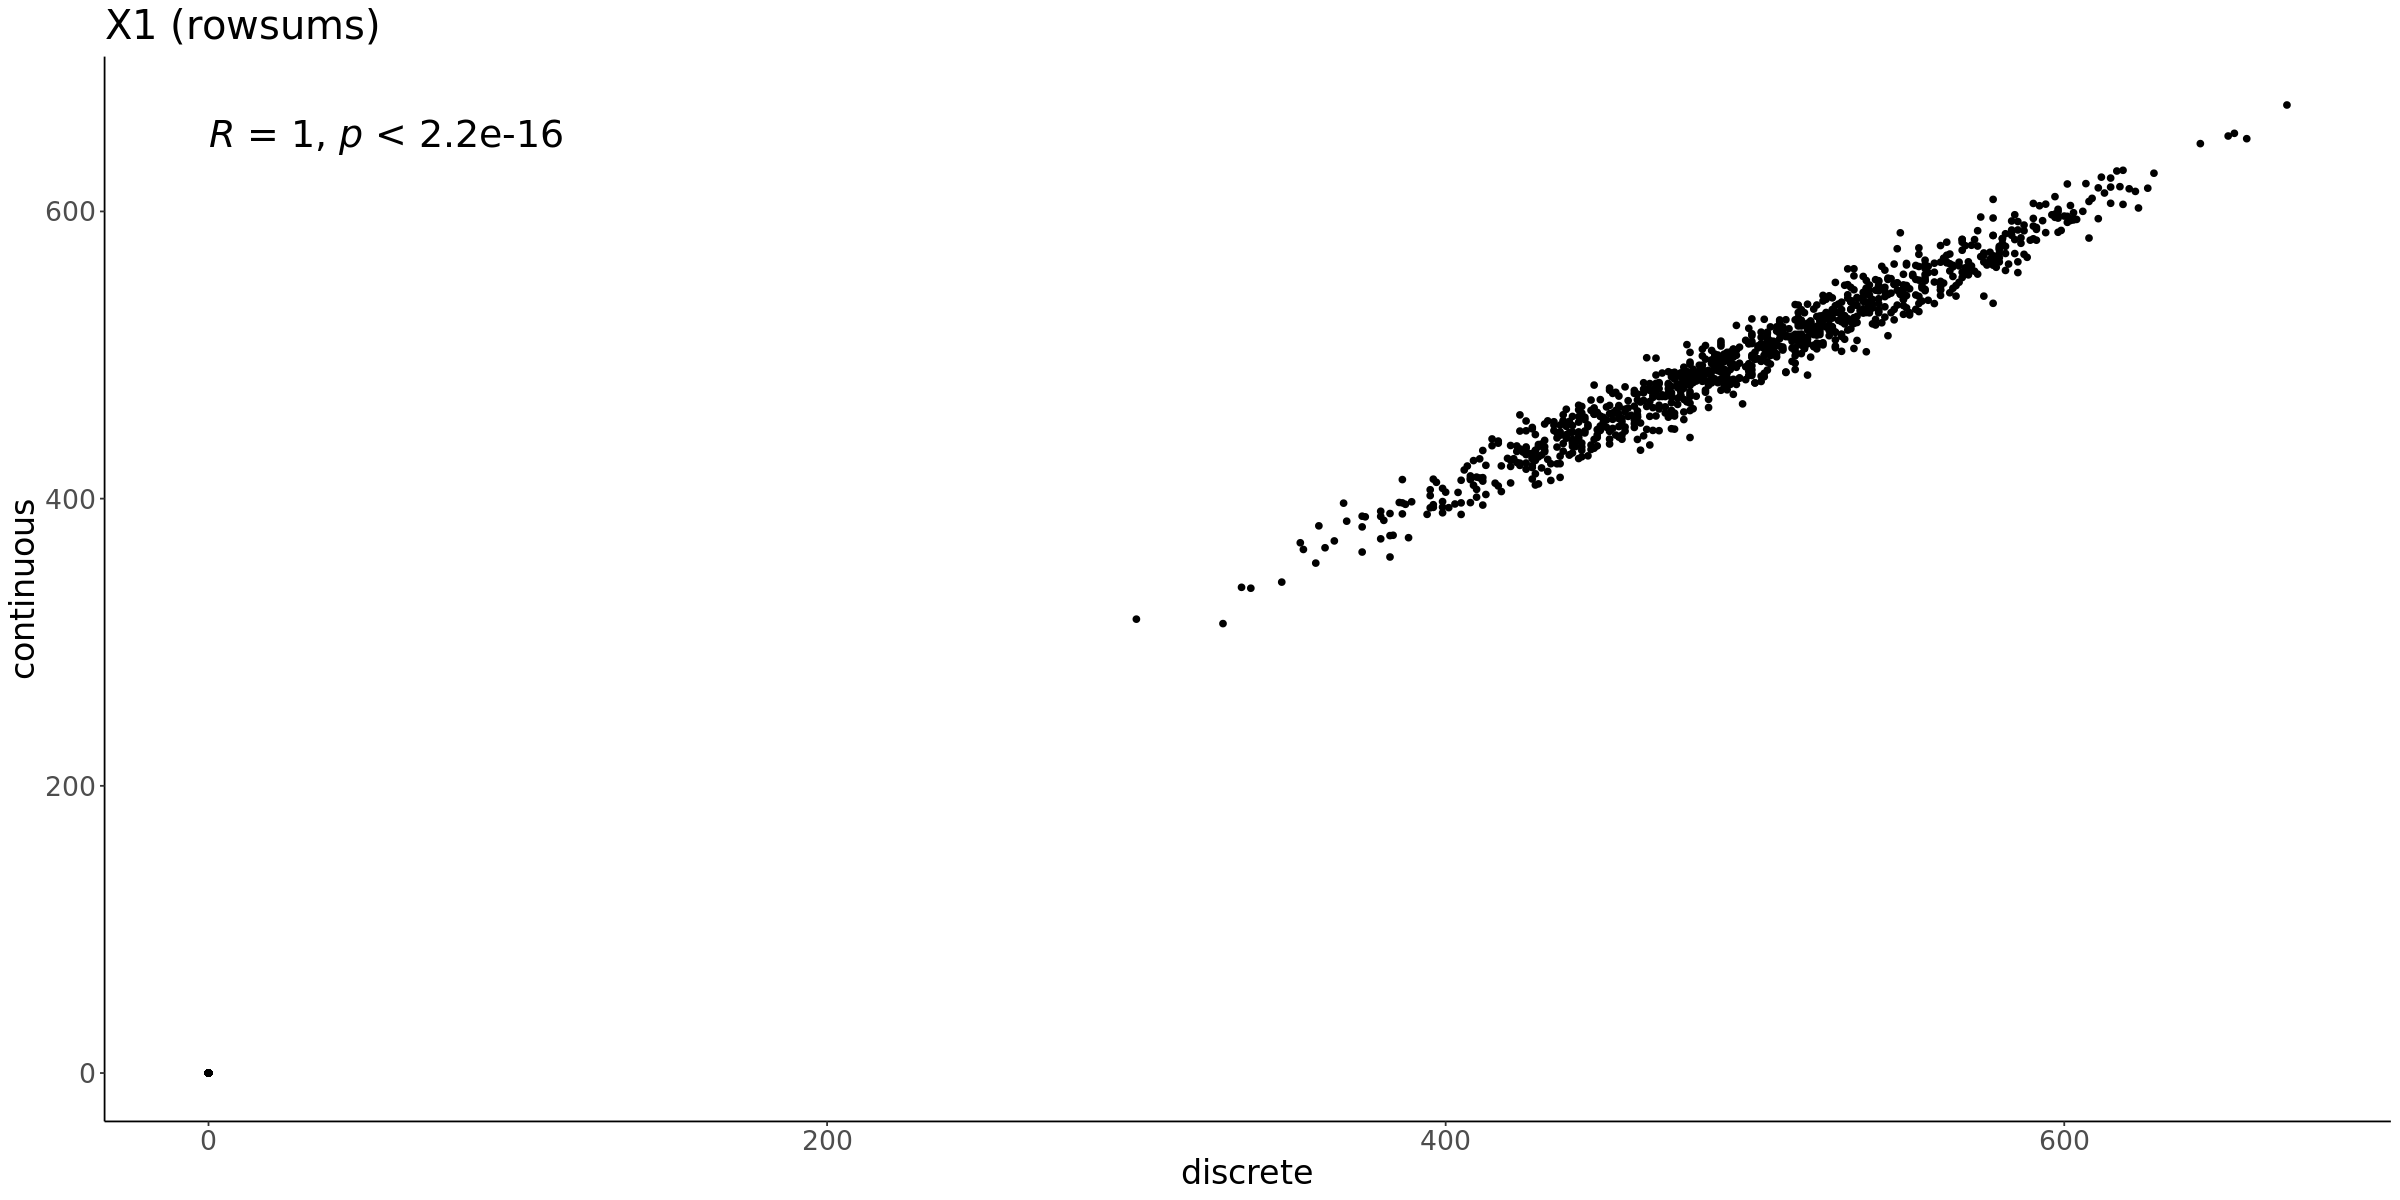

In [8]:
x1.rowsums.df <- data.frame(discrete = x1.dis.rowsums, continuous = x1.cont.rowsums)

x1.scatter <- ggplot(x1.rowsums.df, aes(x = discrete, y = continuous)) + geom_point() + 
                theme_classic() + theme(text = element_text(size = 20)) + ggtitle("X1 (rowsums)") + 
                ggpubr::stat_cor(method = "spearman", show.legend = FALSE, geom = "text", size = 8) 

x1.scatter

In [9]:
tiff("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/x1_scatterplot.tiff",
    res = 100, units = "in", height = 6, width = 6)
print(x1.scatter)
dev.off()

png 
  2

# Load fixed values

Coefficients (ground truth for evaluating model performance) 

Cell cycle scores (same for every gene)

In [52]:
coeffs <- h5read(file = fh, name = "coeffs")
cell.cycle.scores <- h5read(fh, "x/cell_cycle_scores")
percent.mito <- h5read(fh, "x/percent_mito")
scaling.factors <- h5read(file = fh, name = "scaling_factors")
guides.metadata <- h5read(file = fh, name = "guides/metadata")
noisy.d100 <- h5read(file=fh, name = "guides/est_efficiency_D100")

In [5]:
onehot.guides <- h5read(fh, "guides/one_hot")

In [6]:
head(guides.metadata)

,target.gene,efficiency,effect.size
,<int>,<dbl>,<dbl>
1,10227,0.7143842,-5.687418
2,4570,0.4467681,-2.191908
3,8934,0.7701684,-5.064239
4,6939,0.5659939,-6.208954
5,3110,0.5480017,-1.092979
6,8946,0.6334062,-2.452710


In [59]:
genes.to.test <- unique(guides.metadata$target.gene)

for (gene in head(genes.to.test)) {
    print(gene)
}

[1] 10227
[1] 4570
[1] 8934
[1] 6939
[1] 3110
[1] 8946


In [53]:
head(noisy.d100)

[1] 0.5465718 0.5042682 0.4864899 0.5139576 0.5451788 0.5183147

In [45]:
# tg <- sample(guides.metadata$target.gene,1)
tg <- 19
print(tg)

[1] 19


In [54]:
guides.for.gene <- which(guides.metadata$target.gene==tg)
temp.mtx <- t(as.numeric(noisy.d100[guides.for.gene])*t(onehot.guides[,guides.for.gene]))

In [55]:
x1 <- apply(temp.mtx, 1, function(x) {1-prod(1-x)})
sum(x1)

[1] 386.55

In [47]:
as.numeric(guides.metadata$efficiency[guides.for.gene])

[1] 0.8505789 0.3239982 0.6160673 0.5372826

In [48]:
head(t(as.numeric(guides.metadata$efficiency[guides.for.gene])*t(onehot.guides[,guides.for.gene][rowSums(onehot.guides[,guides.for.gene])>1,])) )

0.0000000,0.3239982,0.0000000,0.5372826
0.8505789,0.0000000,0.6160673,0.0000000
0.0000000,0.3239982,0.0000000,0.5372826
0.0000000,0.3239982,0.6160673,0.0000000


In [44]:
1-((1-0.6702509)*(1-0.6122898))

[1] 0.8721529

In [42]:
apply(head(t(as.numeric(guides.metadata$efficiency[guides.for.gene])*t(onehot.guides[,guides.for.gene][rowSums(onehot.guides[,guides.for.gene])>1,])) ),
     1,
     function(x) {1-prod(1-x)})

[1] 0.8721529 0.9309618 0.9331839 0.9309618 0.8762678

In [41]:
head(onehot.guides[,guides.for.gene][rowSums(onehot.guides[,guides.for.gene])>1,])

1,1,0,0
1,0,0,1
0,0,1,1
1,0,0,1
0,1,1,0


In [26]:
head(temp.mtx)

0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0
0,0,0,0


# Define null and alternative models

## Model
$$y = \text{NB}(\mu=s \cdot \exp \left( \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 \right), n=\sigma)$$
### $H_0: \beta_1 = 0 $
### $H_A: \beta_1 \neq 0 $



### Test for one gene (targeting) with `glm.nb` (MASS library)

In [6]:
test.gene <- sample(guides.metadata$target.gene, 1)

print(test.gene)

obs.counts <- h5read(file = fh, name = "counts/discrete", index = list(test.gene, 1:50000))
# obs.counts <- h5read(file = fh, name = "counts/continuous", index = list(test.gene, 1:50000))
gene.data.continuous.x <- data.frame(guide.eff = as.numeric(h5read(file = fh, name = "x/x1_continuous", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                        percent.mito = percent.mito,
                       scaling.factor = scaling.factors)

gene.data.discrete.x <- data.frame(guide.eff = as.numeric(h5read(file = fh, name = "x/x1_discrete", index = list(test.gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                        percent.mito = percent.mito,
                       scaling.factor = scaling.factors)

[1] 11103


In [16]:
head(gene.data.continuous.x)

,guide.eff,s.score,g2m.score,counts,percent.mito,scaling.factor
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,0,0.17229155,-0.15874222,0,0.03069795,0.050107
2,0,-0.11410318,0.20041946,3,0.06200627,0.050082
3,0,-0.05495927,0.03672557,0,0.05384273,0.050384
4,0,-0.07455024,0.27507092,0,0.04150387,0.049990
5,0,0.11608382,-0.21085589,0,0.05731243,0.049868
6,0,0.27953127,-0.17125363,2,0.03168604,0.049912


Model counts simulated from **continuious** $X_1$ using **continuous** $X_1$ values.

In [17]:
ml.cont <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),
             data = gene.data.continuous.x)

In [18]:
summary(ml.cont)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data.continuous.x, 
    init.theta = 1.496047164, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0381  -0.8112  -0.6504   0.2219   3.7916  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.89633    0.01757 107.925  < 2e-16 ***
guide.eff    -1.70049    0.17113  -9.937  < 2e-16 ***
s.score       2.99660    0.07456  40.188  < 2e-16 ***
g2m.score     2.55151    0.03718  68.630  < 2e-16 ***
percent.mito  1.63633    0.38379   4.264 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.496) family taken to be 1)

    Null deviance: 44943  on 49999  degrees of freedom
Residual deviance: 38240  on 49995  degrees of freedom
AIC: 79740

Number of Fisher Scoring iterations: 1


              Theta:  1.4960 
          Std. Err.:  

In [19]:
coeffs[test.gene,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11103,1.88072,-2.493182,2.94906,2.554301,1.907428


Model counts simulated from **continuous** $X_1$ using **discrete** $X_1$ values.

In [20]:
ml.disc <- glm.nb(counts ~ guide.eff + s.score + g2m.score + percent.mito + offset(log(scaling.factor)),
             data = gene.data.discrete.x)

summary(ml.disc)


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + percent.mito + 
    offset(log(scaling.factor)), data = gene.data.discrete.x, 
    init.theta = 1.507704257, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0394  -0.8122  -0.6515   0.2227   3.7985  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.89384    0.01755 107.901  < 2e-16 ***
guide.eff    -2.81834    0.30468  -9.250  < 2e-16 ***
s.score       2.99728    0.07450  40.229  < 2e-16 ***
g2m.score     2.54839    0.03715  68.604  < 2e-16 ***
percent.mito  1.67347    0.38356   4.363 1.28e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5077) family taken to be 1)

    Null deviance: 45015  on 49999  degrees of freedom
Residual deviance: 38194  on 49995  degrees of freedom
AIC: 79635

Number of Fisher Scoring iterations: 1


              Theta:  1.5077 
          Std. Err.:  0

In [21]:
plotdf <- rbind(setNames(coeffs[test.gene,], names(ml.cont$coeff)), rbind(ml.cont$coeff, ml.disc$coeff))
plotdf$label <- c("true","continuous", "discrete")
plotdf

,(Intercept),guide.eff,s.score,g2m.score,percent.mito,label
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
11103,1.880720,-2.493182,2.949060,2.554301,1.907428,true
1,1.896325,-1.700491,2.996604,2.551511,1.636330,continuous
2,1.893844,-2.818342,2.997275,2.548388,1.673471,discrete


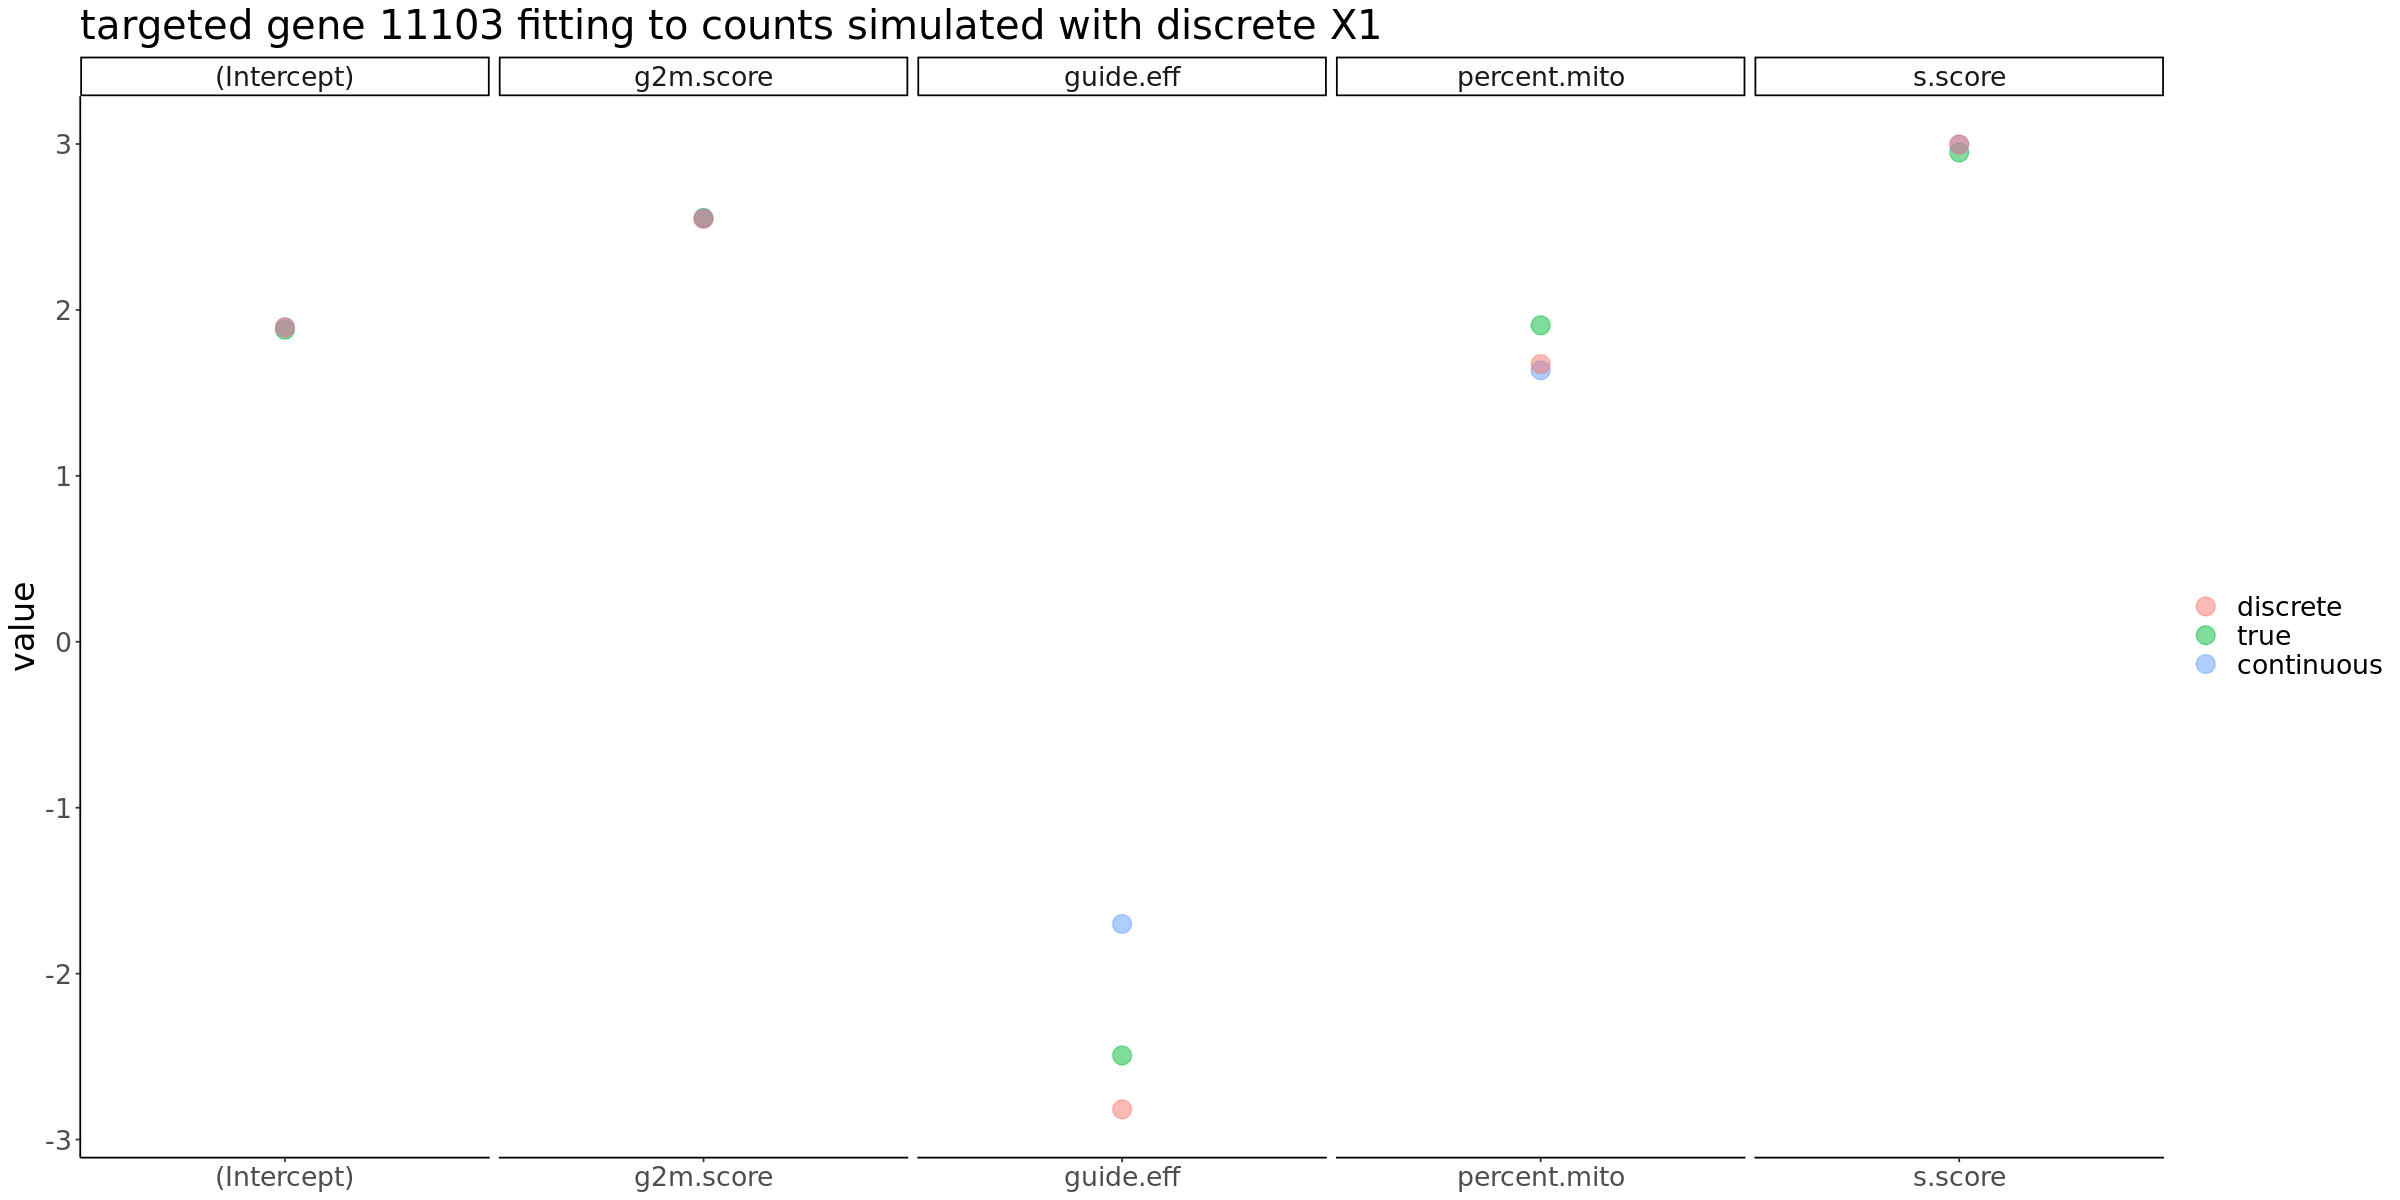

In [22]:
plotdf.long <- tidyr::pivot_longer(plotdf, cols = `(Intercept)`:percent.mito, names_to = "coeff")
plotdf.long$label <- factor(plotdf.long$label, levels=c("discrete","true","continuous"))

ggplot(plotdf.long) + geom_point(aes(x = coeff, y = value, color = label), size = 5, alpha = 0.5) + 
        facet_wrap(vars(coeff), ncol = 5,scales = "free_x") +
#         ggtitle(sprintf("targeted gene %d fitting to counts simulated with continuous X1", test.gene)) +
        ggtitle(sprintf("targeted gene %d fitting to counts simulated with discrete X1", test.gene)) +
        theme_classic() + 
        theme(text = element_text(size = 20), axis.title.x = element_blank(), legend.title = element_blank())

In [36]:
tiff(sprintf("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/gene%s_coeff_estimates_with_discrete_counts.tiff", test.gene),
    res = 300, units = "in", width = 10, height = 5)

ggplot(plotdf.long) + geom_point(aes(x = coeff, y = value, color = label), size = 5, alpha = 0.5) + 
        facet_wrap(vars(coeff), ncol = 5,scales = "free_x") +
#         ggtitle(sprintf("targeted gene %d fitting to counts simulated with continuous X1", test.gene)) +
        ggtitle(sprintf("targeted gene %d fitting to counts simulated with discrete X1", test.gene)) +
        theme_classic() + 
        theme(text = element_text(size = 20), axis.title.x = element_blank(), legend.title = element_blank())

dev.off()

png 
  2

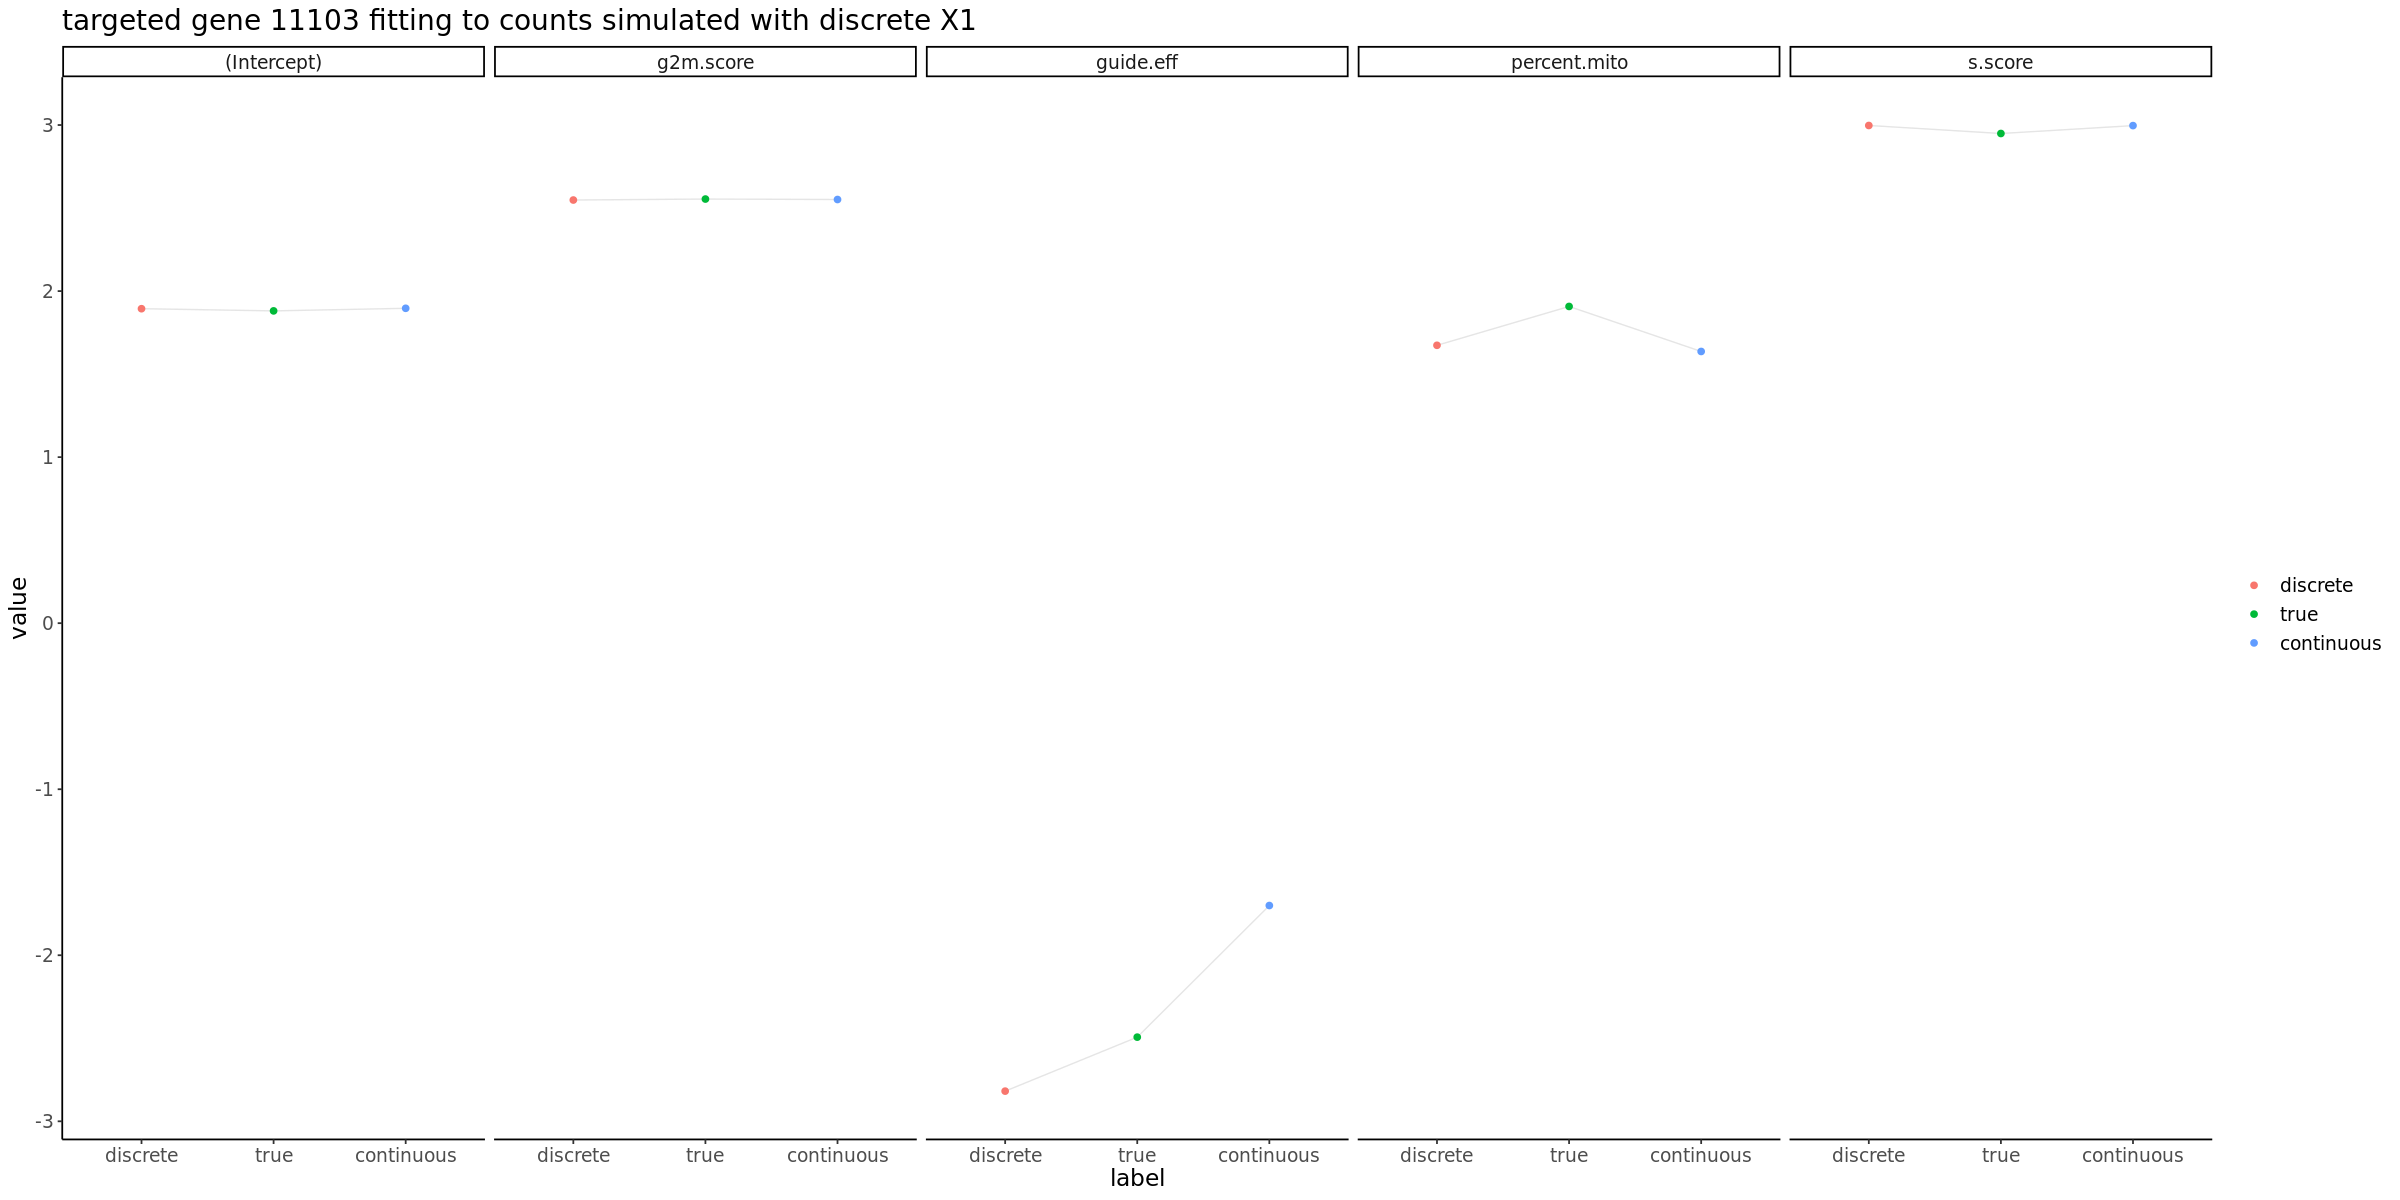

In [24]:
ggplot(data=plotdf.long, aes(x=label, y=value, group = 1)) +
                      geom_line(color = "grey", alpha = 0.4, size = 0.4)+
                      theme_classic() +
                      geom_point(aes(color=label)) + facet_wrap(vars(coeff), ncol = 5, scales = "free_x") +
                    theme(text = element_text(size = 14), legend.title = element_blank()) + 
                    ggtitle(sprintf("targeted gene %d fitting to counts simulated with discrete X1", test.gene))



In [25]:
tiff(sprintf("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/gene%s_coeff_estimates_with_discrete_counts.tiff", test.gene),
    res = 100, units = "in", height = 6, width = 14)

ggplot(data=plotdf.long, aes(x=label, y=value, group = 1)) +
                      geom_line(color = "grey", alpha = 0.4, size = 0.4)+
                      theme_classic() +
                      geom_point(aes(color=label)) + facet_wrap(vars(coeff), ncol = 5, scales = "free_x") +
                    theme(text = element_text(size = 14), legend.title = element_blank()) + 
                    ggtitle(sprintf("targeted gene %d fitting to counts simulated with discrete X1", test.gene))


dev.off()


png(sprintf("/iblm/netapp/data1/jezhou/crisprQTL/simulated_data_4guides_discrete_and_continuous/gene%s_coeff_estimates_with_discrete_counts.png", test.gene),
    res = 300, units = "in", height = 6, width = 14)

ggplot(data=plotdf.long, aes(x=label, y=value, group = 1)) +
                      geom_line(color = "grey", alpha = 0.4, size = 0.4)+
                      theme_classic() +
                      geom_point(aes(color=label)) + facet_wrap(vars(coeff), ncol = 5, scales = "free_x") +
                    theme(text = element_text(size = 14), legend.title = element_blank()) + 
                    ggtitle(sprintf("targeted gene %d fitting to counts simulated with discrete X1", test.gene))


dev.off()

png 
  2

png 
  2

# Test for all target genes

E.g. the 1000 genes in our simulated data whose enhancers are targeted by gRNAs in our library 

In [28]:
ml.list <- list()

for (gene in guides.metadata$target.gene[1:3]) {
    print(gene)
    obs.counts <- h5read(file = fh, name = "counts", index = list(gene, 1:50000))
    gene.data <- data.frame(guide.eff = as.integer(h5read(file = fh, name = "x/x1", index = list(gene, 1:50000))),
                       s.score = cell.cycle.scores$s.scores,
                       g2m.score = cell.cycle.scores$g2m.scores,
                       counts = as.integer(obs.counts),
                       scaling.factors = scaling.factors)
    ml <- glm.nb(counts ~ guide.eff + s.score + g2m.score, data = gene.data)
    ml.list[[gene]] <- ml
}

[1] 3683
[1] 1175
[1] 11331


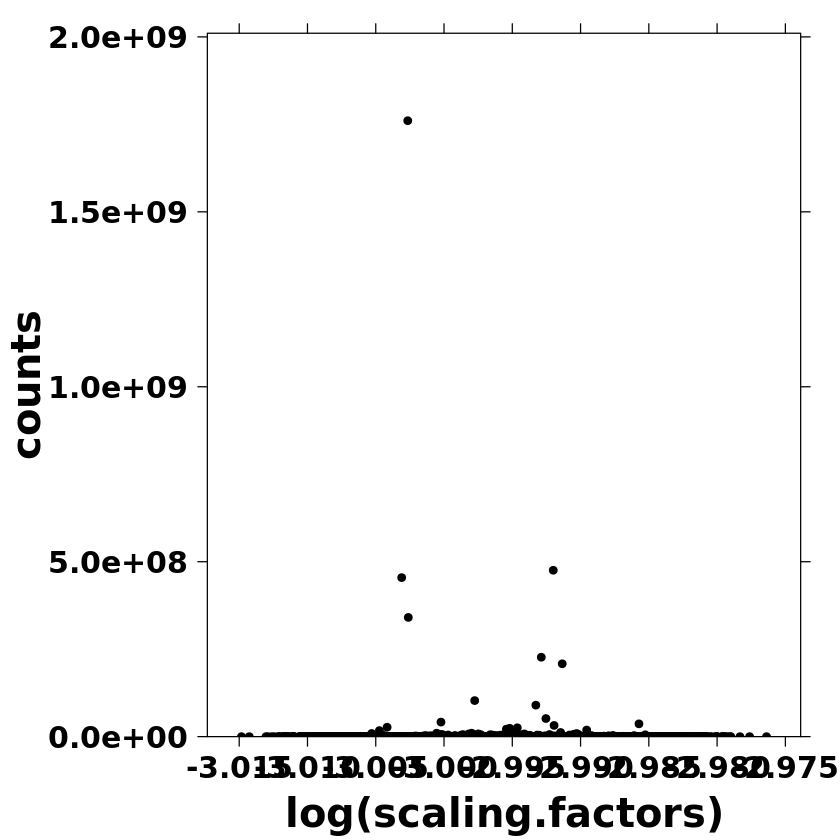

In [29]:
create.scatterplot(
    formula = counts ~ log(scaling.factors),
    data = gene.data
)

In [32]:
cor.test(log(gene.data$scaling.factors), gene.data$counts, method = 'spearman')

Warning message in cor.test.default(log(gene.data$scaling.factors), gene.data$counts, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  log(gene.data$scaling.factors) and gene.data$counts
S = 2.0774e+13, p-value = 0.525
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.002842585 


In [14]:
summary(ml.list[[1175]])


Call:
glm.nb(formula = counts ~ guide.eff + s.score + g2m.score + offset(log(scaling.factors)), 
    data = gene.data, init.theta = 1.517836905, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7483  -0.7233  -0.3835  -0.0663   4.2255  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.82181    0.01076 169.385  < 2e-16 ***
guide.eff   -5.19567    0.71304  -7.287 3.18e-13 ***
s.score      3.05735    0.01492 204.953  < 2e-16 ***
g2m.score    2.33210    0.01370 170.213  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.5178) family taken to be 1)

    Null deviance: 131409  on 49999  degrees of freedom
Residual deviance:  34801  on 49996  degrees of freedom
AIC: 99823

Number of Fisher Scoring iterations: 1


              Theta:  1.5178 
          Std. Err.:  0.0280 

 2 x log-likelihood:  -99813.2890 

In [15]:
coeffs[1175,]

,baselines,beta1,beta2,beta3,beta4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1175,1.766874,-4.83825,3.061181,2.336816,1.22111
